In [123]:
import os
print(os.getcwd())

import numpy as numpy
import pandas as pd
from collections import Counter

from sklearn.model_selection import train_test_split

import string
import nltk
from nltk.tokenize import WordPunctTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))



/Users/ilyagrachev/github/personal/news_nlp/ref


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ilyagrachev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Datasets preparation

In [176]:
# strip data of text labels and separate articles and labels

data = pd.read_parquet('../misc/data/raw.parquet')

labels = data[['label', 'label_text']].drop_duplicates('label').sort_values(by='label')
with open('../misc/data/txt_labels.txt', 'w') as file:
    for row in labels.values:
        file.write(f'{str(row[0])} {row[1]}')
    del labels

data.drop(columns=['label_text'], inplace=True)

X_train, X_val, y_train, y_val = train_test_split(data[['text']], data[['label']], train_size=0.8, random_state=235)

X_train.to_parquet('../misc/data/text_train.parquet', index=False)
X_val.to_parquet('../misc/data/text_val.parquet', index=False)
y_train.to_parquet('../misc/data/labels_train.parquet', index=False)
y_val.to_parquet('../misc/data/labels_val.parquet', index=False)


In [ ]:
data = list(pd.read_parquet('../misc/data/text_train.parquet').loc[:, 'text'])
val = list(pd.read_parquet('../misc/data/text_val.parquet').loc[:, 'text'])


# Tokenization

In [ ]:


def tokenize(article: str):
    # tokenize
    tokens = tokenizer.tokenize(article)
    
    # remove numbers and punctuation, lower
    tokens = [stemmer.stem(token.lower()) for token in tokens if (token.lower().isalpha() and token.lower() not in stop_words)]
    return tokens


tokenizer = WordPunctTokenizer()
stemmer = PorterStemmer()
token_counter = Counter()
tokenized = []
for article in data:
    temp = tokenize(article)
    tokenized.append(temp)
    token_counter.update(temp)
    del temp

val_tokenized = []
for article in val:
    val_tokenized.append(tokenize(article))

vocab = dict(zip(token_counter.keys(), list(range(0, len(token_counter)))))
vocab['UNK'] = len(vocab)
vocab['PAD'] = len(vocab)
print('Total dictionary consists of', len(token_counter), 'tokens')


# TF-IDF

In [172]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pyarrow

In [ ]:
baseline_corpus = [' '.join(article) for article in tokenized]
baseline_corpus_val = [' '.join(article) for article in val_tokenized]

tfidf = TfidfVectorizer(lowercase=False, vocabulary=vocab)
tfidf_embeddings = tfidf.fit_transform(baseline_corpus)
tfidf_embeddings_val = tfidf.transform(baseline_corpus_val)

pd.DataFrame(tfidf_embeddings.toarray(), columns=list(vocab.keys())).to_parquet('../misc/embedded/tfidf_train.parquet', index=False)
pd.DataFrame(tfidf_embeddings_val.toarray(), columns=list(vocab.keys())).to_parquet('../misc/embedded/tfidf_val.parquet', index=False)

# Classification

In [53]:
import os
print(os.getcwd())

import numpy as numpy
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb

from sklearn.metrics import confusion_matrix, classification_report


/Users/ilyagrachev/github/personal/news_nlp/ref


In [6]:
emb_train = pd.read_parquet('../misc/embedded/tfidf_train.parquet')
label_train = pd.read_parquet('../misc/data/labels_train.parquet')
emb_val = pd.read_parquet('../misc/embedded/tfidf_val.parquet')
label_val = pd.read_parquet('../misc/data/labels_val.parquet')


[]

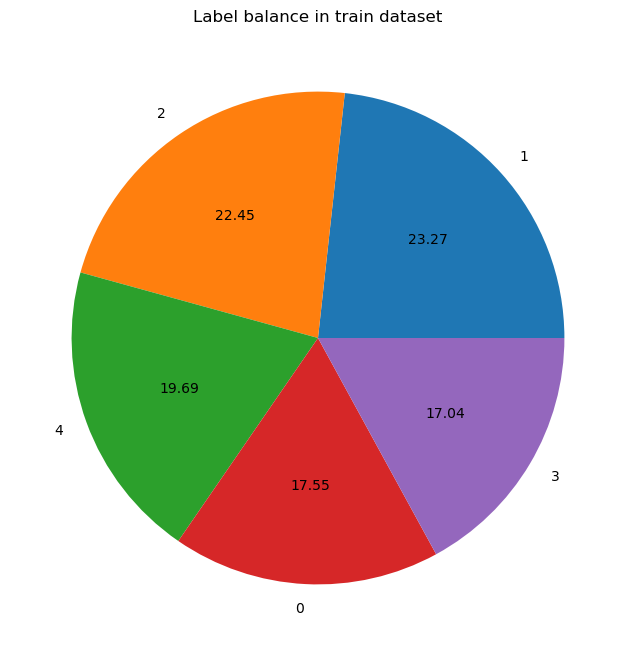

In [38]:
plt.figure(figsize=(8,8))
plt.pie(list(label_train.value_counts().values), labels=[l[0] for l in label_train.value_counts().index], autopct='%.2f')
plt.title('Label balance in train dataset')
plt.plot()


In [ ]:
train_data = lgb.Dataset(emb_train.values, label=label_train.values, feature_name=list(emb_train.columns))
validation_data = lgb.Dataset(emb_val.values, label=label_val.values, feature_name=list(emb_val.columns), reference=train_data)

params = {'objective': 'multiclass', 'num_class': 5, 'metric': 'multi_logloss', 'num_threads': -1, 'seed': 124, 'early_stopping_round': 5}

boosting = lgb.train(params=params, train_set=train_data, valid_sets=(validation_data, ))
boosting_val = np.argmax(boosting.predict(emb_val), axis=1)


/Users/ilyagrachev/anaconda3/envs/nlp/lib/python3.11/site-packages/lightgbm/basic.py:374: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.108413 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 35249
[LightGBM] [Info] Number of data points in the train set: 980, number of used features: 1495
[LightGBM] [Info] Start training from score -1.740058
[LightGBM] [Info] Start training from score -1.458207
[LightGBM] [Info] Start training from score -1.493925
[LightGBM] [Info] Start training from score -1.769559
[LightGBM] [Info] Start training from score -1.624862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
T

[]

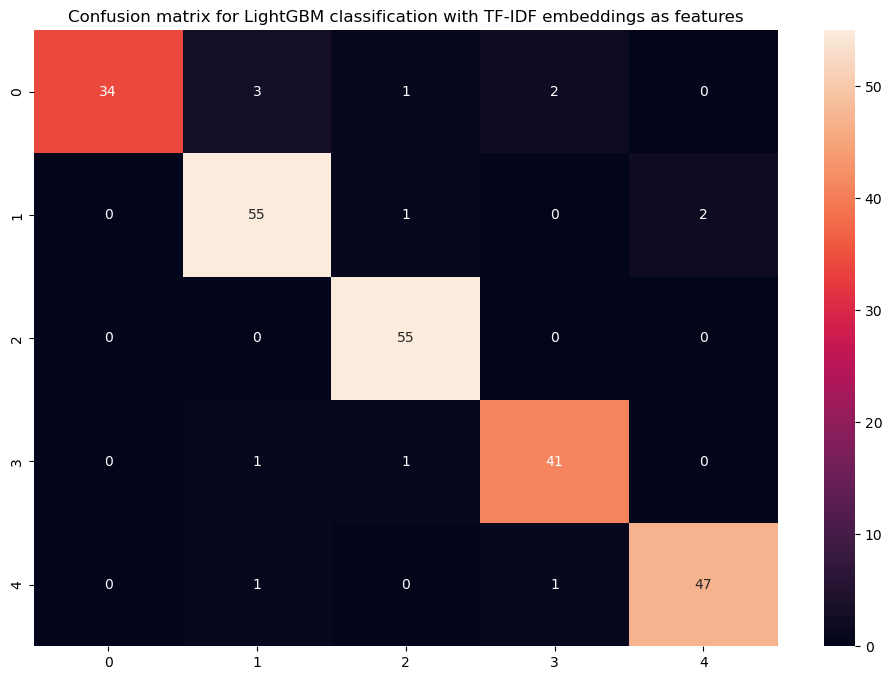

In [58]:
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_matrix(label_val, boosting_val), annot=True, )
plt.title('Confusion matrix for LightGBM classification with TF-IDF embeddings as features')
plt.plot()


In [59]:
print(classification_report(label_val, boosting_val))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92        40
           1       0.92      0.95      0.93        58
           2       0.95      1.00      0.97        55
           3       0.93      0.95      0.94        43
           4       0.96      0.96      0.96        49

    accuracy                           0.95       245
   macro avg       0.95      0.94      0.95       245
weighted avg       0.95      0.95      0.95       245



In [128]:
# print(token_counter.most_common()[:20])
print(token_counter.most_common()[-20:])

[('separatist', 1), ('berat', 1), ('homesick', 1), ('jockey', 1), ('ordeal', 1), ('dredg', 1), ('meghan', 1), ('dirrti', 1), ('fiance', 1), ('marmalad', 1), ('maya', 1), ('missi', 1), ('pent', 1), ('talktalk', 1), ('antwerp', 1), ('willem', 1), ('stretcher', 1), ('gameplan', 1), ('goalscor', 1), ('boavista', 1)]


In [55]:
data[0].translate(string.punctuation)

'wales want rugby league training wales could follow england s lead by training with a rugby league club.  england have already had a three-day session with leeds rhinos  and wales are thought to be interested in a similar clinic with rivals st helens. saints coach ian millward has given his approval  but if it does happen it is unlikely to be this season. saints have a week s training in portugal next week  while wales will play england in the opening six nations match on 5 february.  we have had an approach from wales   confirmed a saints spokesman.  it s in the very early stages but it is something we are giving serious consideration to.  st helens  who are proud of their welsh connections  are obvious partners for the welsh rugby union  despite a spat in 2001 over the collapse of kieron cunningham s proposed £500 000 move to union side swansea. a similar cross-code deal that took iestyn harris from leeds to cardiff in 2001 did go through  before the talented stand-off returned to t

In [57]:
data[1]

'china aviation seeks rescue deal scandal-hit jet fuel supplier china aviation oil has offered to repay its creditors $220m (£117m) of the $550m it lost on trading in oil futures.  the firm said it hoped to pay $100m now and another $120m over eight years. with assets of $200m and liabilities totalling $648m  it needs creditors  backing for the offer to avoid going into bankruptcy. the trading scandal is the biggest to hit singapore since the $1.2bn collapse of barings bank in 1995. chen jiulin  chief executive of china aviation oil (cao)  was arrested by at changi airport by singapore police on 8 december. he was returning from china  where he had headed when cao announced its trading debacle in late-november. the firm had been betting heavily on a fall in the price of oil during october  but prices rose sharply instead.  among the creditors whose backing cao needs for its restructuring plan are banking giants such as barclay s capital and sumitomo mitsui  as well as south korean firm

In [58]:
data[2]

'rock band u2 break ticket record u2 have smashed irish box office records with ticket sales for their dublin concerts  after more than 150 000 were sold within 50 minutes.  tickets for the two concerts at the city s croke park stadium were released at 8am on friday morning.  nothing like it has ever been seen in ireland before   said justin green  spokesman for organisers mcd promoters.  we could have sold a million tickets.  the dublin dates on june 24 and 25 form part of the worldwide vertigo tour. the tour begins in san diego on 28 march and will cover 13 us cities. the band will also play 24 european gigs  finishing in lisbon in august.  mr green said that ticket outlets had been  bombarded  by u2 fans.  unfortunately there s thousands and thousands of disappointed fans all over the country which is disappointing  but there s only two dates confirmed   he said. many fans camped on the streets of the irish capital for three days to ensure they were first in line at ticketmaster in 